In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set the image size and other parameters
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50

# Define the paths for training and validation directories
train_directory = '/kaggle/input/fyp-eyepacs-progressionv2/FYP-EYEPACS-Progressionv2'
valid_directory = '/kaggle/input/fyp-ddr-progressionv22jpegtest/FYP-DDR-Progressionv2.2jpegtest/test'

# Define the pre-processing functions
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def preprocess_image(path, sigmaX=10):
    image = cv2.imread(path)
    if image is None:
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)

    return image

# Load and preprocess the data
train_data = []
train_labels = []

# Load images from the "No-DR" class
no_dr_path = os.path.join(train_directory, "0")
for filename in os.listdir(no_dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(no_dr_path, filename)
        image = preprocess_image(image_path)
        if image is not None:
            train_data.append(image)
            train_labels.append(0)

# Load images from the "DR" class
dr_path = os.path.join(train_directory, "1")
for filename in os.listdir(dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(dr_path, filename)
        image = preprocess_image(image_path)
        if image is not None:
            train_data.append(image)
            train_labels.append(1)

# Convert the data and labels to NumPy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# One-hot encode the labels
train_labels = to_categorical(train_labels)

# Split the data into training and validation sets
#train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
  


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:

# Load and preprocess the data
valid_data = []
valid_labels = []

# Load images from the "No-DR" class
no_dr_path = os.path.join(valid_directory, "0")
for filename in os.listdir(no_dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(no_dr_path, filename)
        image = preprocess_image(image_path)
        if image is not None:
            valid_data.append(image)
            valid_labels.append(0)

# Load images from the "DR" class
dr_path = os.path.join(valid_directory, "1")
for filename in os.listdir(dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(dr_path, filename)
        image = preprocess_image(image_path)
        if image is not None:
            valid_data.append(image)
            valid_labels.append(1)

# Convert the data and labels to NumPy arrays
val_data = np.array(valid_data)
val_labels = np.array(valid_labels)

# One-hot encode the labels
val_labels = to_categorical(valid_labels)


In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the MobileNetV2 model (excluding the top fully-connected layers)
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")

# Freeze the base model layers
base_model.trainable = True

# Create the model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


# Define callbacks for early stopping, model checkpoint, and reduce on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/updated/best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Compile the model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()



9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

In [4]:
# Load the saved model weights
#model.load_weights('/kaggle/working/updated/best_model.h5')

# Train the model
history = model.fit(train_data, train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=EPOCHS,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])



Epoch 1/50
583/583 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.6477
Epoch 1: val_loss improved from inf to 0.73661, saving model to /kaggle/working/updated/best_model.h5
583/583 [==============================] - 123s 132ms/step - loss: 0.6370 - accuracy: 0.6477 - val_loss: 0.7366 - val_accuracy: 0.6061 - lr: 1.0000e-04
Epoch 2/50
583/583 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7202
Epoch 2: val_loss did not improve from 0.73661
583/583 [==============================] - 80s 137ms/step - loss: 0.5437 - accuracy: 0.7202 - val_loss: 0.8923 - val_accuracy: 0.6235 - lr: 1.0000e-04
Epoch 3/50
583/583 [==============================] - ETA: 0s - loss: 0.4779 - accuracy: 0.7659
Epoch 3: val_loss did not improve from 0.73661
583/583 [==============================] - 80s 137ms/step - loss: 0.4779 - accuracy: 0.7659 - val_loss: 1.1389 - val_accuracy: 0.5672 - lr: 1.0000e-04
Epoch 4/50
583/583 [==============================] - ETA: 0s 

157/157 [==============================] - 6s 37ms/step - loss: 0.6558 - accuracy: 0.6808
Validation loss: 0.6557939648628235
Validation accuracy: 0.6807661652565002


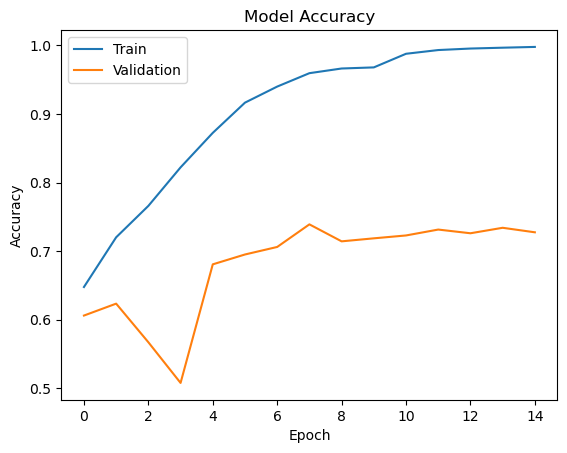

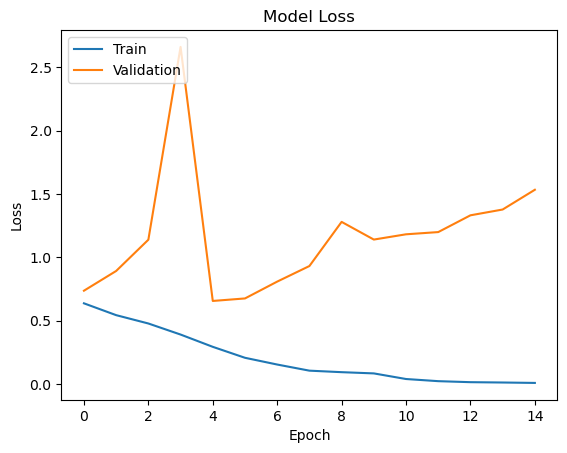

In [5]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data, val_labels)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [6]:
# Make predictions on the validation dataset
predictions = model.predict(val_data)
y_pred = np.argmax(predictions, axis=1)

# Compute precision, recall, accuracy, and F1 score for each class
precision = precision_score(np.argmax(val_labels, axis=1), y_pred, average=None)
recall = recall_score(np.argmax(val_labels, axis=1), y_pred, average=None)
f1 = f1_score(np.argmax(val_labels, axis=1), y_pred, average=None)
accuracy = accuracy_score(np.argmax(val_labels, axis=1), y_pred)

# Display the metrics for each class
class_labels = ['0', '1']  # Update with your class labels

for i, class_label in enumerate(class_labels):
    print(f'Class: {class_label}')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1 Score: {f1[i]}')
    print('---')

# Display overall accuracy
print('Overall Accuracy:', accuracy)


157/157 [==============================] - 6s 34ms/step
Class: 0
Precision: 0.7569405099150142
Recall: 0.5329078579976066
F1 Score: 0.6254681647940075
---
Class: 1
Precision: 0.6393594086849399
Recall: 0.8287425149700599
F1 Score: 0.7218358831710708
---
Overall Accuracy: 0.6807661612130886


In [15]:
import numpy as np
from PIL import Image
from keras.models import load_model
image_width = 224
image_height = 224
confidence = None

# Load the saved model
model = load_model('/kaggle/input/bestmodel20/best_model (20).h5')

# Load and preprocess the image
image_path = '/kaggle/input/imagetest3/imagetestdr/2302Diabetic_retinopathy_CH.jpg'
image = Image.open(image_path)
image = image.resize((image_width, image_height))  # Adjust the size according to your model's input shape
image = np.array(image)
#image = image / 255.0  # Normalize the image data

# Perform the prediction
predictions = model.predict(np.expand_dims(image, axis=0))
predicted_label = np.argmax(predictions[0])
global confidence
confidence = np.max(predictions)

# Print the predicted label
if predicted_label == 0:
    print("Predicted label: no-DR")
    print(confidence)
elif predicted_label == 1:
    print("Predicted label: DR")
    print(confidence)
else:
    print("Invalid label predicted")

1/1 [==============================] - 1s 777ms/step
Predicted label: DR
0.9413816


In [ ]:
#Transfer Learning

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set the image size and other parameters
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50

# Define the paths for training and validation directories
train_directory = '/kaggle/input/fyp-ddr-progressionv22jpeg/FYP-DDR-Progressionv2.2jpeg/train'
valid_directory = '/kaggle/input/fyp-ddr-progressionv22jpegtest/FYP-DDR-Progressionv2.2jpegtest/test'

# Define the pre-processing functions
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def preprocess_image(path, sigmaX=10):
    image = cv2.imread(path)
    if image is None:
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)

    return image

# Load and preprocess the data
train_data = []
train_labels = []

# Load images from the "No-DR" class
no_dr_path = os.path.join(train_directory, "0")
for filename in os.listdir(no_dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(no_dr_path, filename)
        image = preprocess_image(image_path)
        if image is not None:
            train_data.append(image)
            train_labels.append(0)

# Load images from the "DR" class
dr_path = os.path.join(train_directory, "1")
for filename in os.listdir(dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(dr_path, filename)
        image = preprocess_image(image_path)
        if image is not None:
            train_data.append(image)
            train_labels.append(1)

# Convert the data and labels to NumPy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# One-hot encode the labels
train_labels = to_categorical(train_labels)

# Split the data into training and validation sets
#train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
  


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:

# Load and preprocess the data
valid_data = []
valid_labels = []

# Load images from the "No-DR" class
no_dr_path = os.path.join(valid_directory, "0")
for filename in os.listdir(no_dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(no_dr_path, filename)
        image = preprocess_image(image_path)
        if image is not None:
            valid_data.append(image)
            valid_labels.append(0)

# Load images from the "DR" class
dr_path = os.path.join(valid_directory, "1")
for filename in os.listdir(dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(dr_path, filename)
        image = preprocess_image(image_path)
        if image is not None:
            valid_data.append(image)
            valid_labels.append(1)

# Convert the data and labels to NumPy arrays
val_data = np.array(valid_data)
val_labels = np.array(valid_labels)

# One-hot encode the labels
val_labels = to_categorical(valid_labels)


In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
# Load the MobileNetV2 model (excluding the top fully-connected layers)
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")

# Freeze the base model layers
base_model.trainable = True

# Create the model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])



9406464/9406464 [==============================] - 0s 0us/step


In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Load the saved model for transfer learning
saved_model_path = '/kaggle/input/bestmodel20/best_model (20).h5'
model.load_weights(saved_model_path)

# Define callbacks for early stopping, model checkpoint, and reduce on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/updated/best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Print the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

In [5]:
# Load the saved model weights
#model.load_weights('/kaggle/working/updated/best_model.h5')

# Train the model
history = model.fit(train_data, train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=EPOCHS,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])



Epoch 1/50
235/235 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8344
Epoch 1: val_loss improved from inf to 0.67201, saving model to /kaggle/working/updated/best_model.h5
235/235 [==============================] - 87s 180ms/step - loss: 0.3745 - accuracy: 0.8344 - val_loss: 0.6720 - val_accuracy: 0.7783 - lr: 1.0000e-04
Epoch 2/50
235/235 [==============================] - ETA: 0s - loss: 0.2313 - accuracy: 0.9055
Epoch 2: val_loss improved from 0.67201 to 0.62637, saving model to /kaggle/working/updated/best_model.h5
235/235 [==============================] - 39s 168ms/step - loss: 0.2313 - accuracy: 0.9055 - val_loss: 0.6264 - val_accuracy: 0.7668 - lr: 1.0000e-04
Epoch 3/50
235/235 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9478
Epoch 3: val_loss did not improve from 0.62637
235/235 [==============================] - 35s 147ms/step - loss: 0.1334 - accuracy: 0.9478 - val_loss: 0.6469 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoc

157/157 [==============================] - 6s 37ms/step - loss: 0.6112 - accuracy: 0.8591
Validation loss: 0.6112002730369568
Validation accuracy: 0.8591380715370178


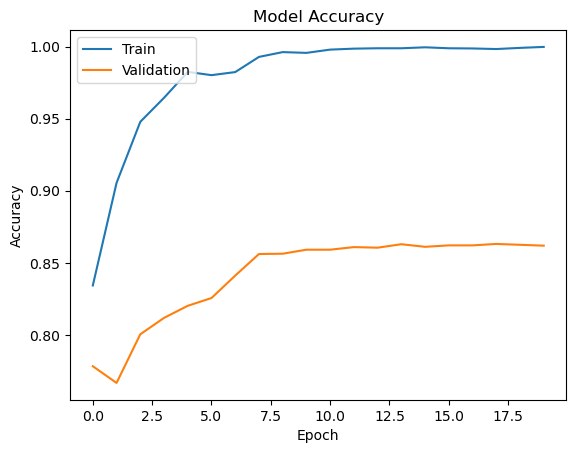

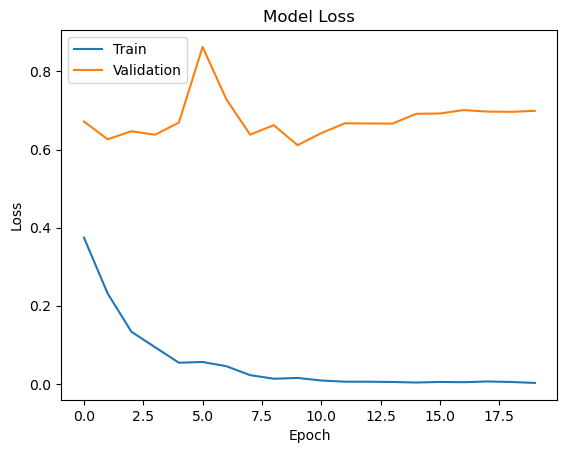

In [6]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data, val_labels)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [7]:
# Make predictions on the validation dataset
predictions = model.predict(val_data)
y_pred = np.argmax(predictions, axis=1)

# Compute precision, recall, accuracy, and F1 score for each class
precision = precision_score(np.argmax(val_labels, axis=1), y_pred, average=None)
recall = recall_score(np.argmax(val_labels, axis=1), y_pred, average=None)
f1 = f1_score(np.argmax(val_labels, axis=1), y_pred, average=None)
accuracy = accuracy_score(np.argmax(val_labels, axis=1), y_pred)

# Display the metrics for each class
class_labels = ['0', '1']  # Update with your class labels

for i, class_label in enumerate(class_labels):
    print(f'Class: {class_label}')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1 Score: {f1[i]}')
    print('---')

# Display overall accuracy
print('Overall Accuracy:', accuracy)


157/157 [==============================] - 6s 34ms/step
Class: 0
Precision: 0.8304587155963302
Recall: 0.9026725169525329
F1 Score: 0.8650611620795107
---
Class: 1
Precision: 0.8933100131176214
Recall: 0.8155688622754491
F1 Score: 0.852671118530885
---
Overall Accuracy: 0.8591380686352753


In [39]:
import numpy as np
from PIL import Image
from keras.models import load_model
image_width = 224
image_height = 224
confidence = None

# Load the saved model
model = load_model('/kaggle/input/bestmodel22/best_model (22).h5')

# Load and preprocess the image
image_path = '/kaggle/input/dataset/Dataset/Dataset/1/WhatsApp Image 2023-06-17 at 12.49.37 PM.jpeg'
image = Image.open(image_path)
image = image.resize((image_width, image_height))  # Adjust the size according to your model's input shape
image = np.array(image)
#image = image / 255.0  # Normalize the image data

# Perform the prediction
predictions = model.predict(np.expand_dims(image, axis=0))
predicted_label = np.argmax(predictions[0])
global confidence
confidence = np.max(predictions)

# Print the predicted label
if predicted_label == 0:
    print("Predicted label: no-DR")
    print(confidence)
elif predicted_label == 1:
    print("Predicted label: DR")
    print(confidence)
else:
    print("Invalid label predicted")

1/1 [==============================] - 1s 1s/step
Predicted label: DR
1.0
